In [1]:
import msprime
import pyslim
import numpy as np
import subprocess
import tskit
from matplotlib import pyplot as plt
import matplotlib.colors as colors

from IPython.display import display

# Neutral simulation

## The coalescent

In [2]:
demog_model = msprime.Demography()
demog_model.add_population(initial_size=5_000)
ots = msprime.sim_ancestry(
        samples=1_000,
        demography=demog_model,
        random_seed=5,
        recombination_rate=1e-8,
        sequence_length = 90_000_000)

## Annotating everyone

In [3]:
ots = pyslim.annotate(ots, model_type="WF", tick=1, stage="late")

## Add SLiM mutations

In [4]:
breaks = [0, 30_000_000, 60_000_000, 90_000_000]

mut_map = msprime.RateMap(
           position=breaks,
           rate=[0, 30e-11, 0])
mut_model = msprime.SLiMMutationModel(type=2)
ots = msprime.sim_mutations(
            ots,
            rate=mut_map,
            model=mut_model,
            keep=False, 
            random_seed=123)
print(f"The tree sequence now has {ots.num_mutations} mutations, at "
      f"{ots.num_sites} distinct sites.")

The tree sequence now has 1434 mutations, at 1434 distinct sites.


## Assigning selection coefficients

In [5]:
mean_s = 0.004
rng = np.random.default_rng(seed=1234)
tables = ots.tables
tables.mutations.clear()
mut_map = {}
for m in ots.mutations():
  md_list = m.metadata["mutation_list"]
  slim_ids = m.derived_state.split(",")
  assert len(slim_ids) == len(md_list)
  for sid, md in zip(slim_ids, md_list):
     if sid not in mut_map:
        mut_map[sid] = rng.exponential(scale=mean_s)
     md["selection_coeff"] = mut_map[sid]
  _ = tables.mutations.append(
          m.replace(metadata={"mutation_list": md_list})
  )

# check we didn't mess anything up
assert tables.mutations.num_rows == ots.num_mutations
print(f"The selection coefficients range from {min(mut_map.values()):0.2e}")
print(f"to {max(mut_map.values()):0.2e}.")

ots = tables.tree_sequence()
ots.dump("vignette_annotated.init.trees")

The selection coefficients range from 3.68e-07
to 3.51e-02.


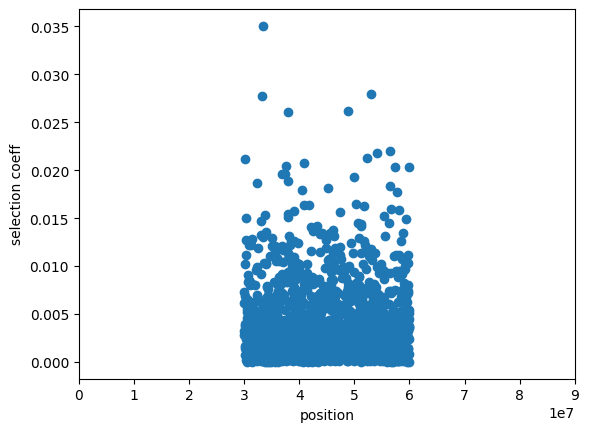

In [6]:
fig, ax = plt.subplots()
ax.scatter(ots.sites_position[ots.mutations_site],
           [sum([x['selection_coeff'] for x in m.metadata['mutation_list']]) for m in ots.mutations()]
          )
ax.set_xlabel("position"); ax.set_ylabel("selection coeff")
ax.set_xlim(0, ots.sequence_length);

## Running SLiM simulation

In [7]:
msg = subprocess.check_output(
     ["slim", "-d", f"L={int(ots.sequence_length)}",
      "-d", f"S={mean_s}",
      "-s", "5", "reload_annotated.slim"])
print(msg.decode())

// Initial random seed:
5

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'WF');
initializeTreeSeq();
initializeMutationRate(c(3e-11, 3e-12, 3e-11), c(29999999, 59999999, 89999999));
initializeMutationType(1, 0.5, "f", 0);
initializeMutationType(2, 0.5, "e", 0.004);
initializeGenomicElementType(1, m2, 1);
initializeGenomicElement(g1, 0, 89999999);
initializeRecombinationRate(1e-08);

// Starting run at tick <start>:
1 

Done.



# Analysis

In [8]:
ts = tskit.load("vignette_annotated.trees")
num_stacked = np.array([len(m.metadata["mutation_list"]) for m in ts.mutations()])
init_time = ts.metadata['SLiM']['tick']
old_mut = np.array([m.time > init_time - 1 - 1e-12 for m in ts.mutations()])
assert sum(old_mut) == ots.num_mutations
print(f"There are {ts.num_mutations} present at {ts.num_sites} distinct sites.")
print(f"Of these, {np.sum(num_stacked > 1)} have more than one stacked mutation,")
print(f"and {np.sum(old_mut)} were produced by msprime.")

There are 1477 present at 1477 distinct sites.
Of these, 0 have more than one stacked mutation,
and 1434 were produced by msprime.


In [9]:
times = list(set(ts.individuals_time))
times.sort()
print("The times ago at which individuals in the tree sequence were born:", times)
# The times ago at which individuals in the tree sequence were born: [0.0, 100.0]
nodes_by_time = [ts.samples(time=t) for t in times]

num_nodes = np.array([len(x) for x in nodes_by_time])
p = ts.sample_count_stat(nodes_by_time, lambda x: x/num_nodes, 2, windows='sites',
        strict=False, span_normalise=False, polarised=True)
s = np.array([sum([sum([md["selection_coeff"] for md in m.metadata["mutation_list"]])
                  for m in site.mutations]) for site in ts.sites()])

The times ago at which individuals in the tree sequence were born: [np.float64(0.0), np.float64(499.0)]


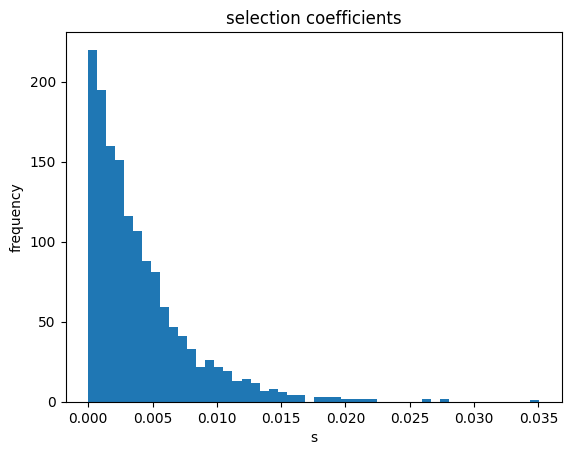

In [10]:
fig, ax = plt.subplots()
ax.hist(s, bins=50)
ax.set_title("selection coefficients")
ax.set_xlabel("s"); ax.set_ylabel("frequency");

In [11]:
for j, v in enumerate(ts.variants()):
  if len(v.site.mutations) > 1:
     print(f"Site {j} has {num_stacked[j]} stacked mutations, "
           f"with total derived allele frequency {p[j]} "
           f"and sum of selection coefficients {s[j]}.")
     print(f"The allele frequencies are:")
     for k, a in enumerate(v.alleles):
        print(f"  '{a}': {sum(v.genotypes == k)}")
     print(v.site)

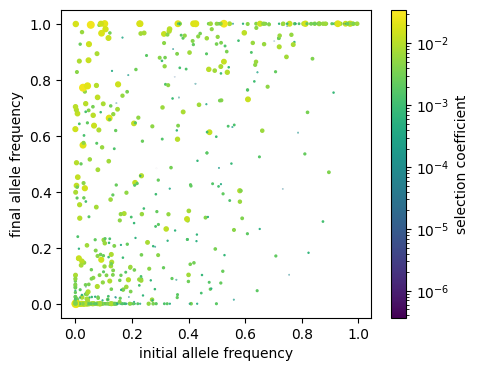

In [12]:
fig, ax1 = plt.subplots(figsize=(5, 4))
dp = ax1.scatter(p[:, 1], p[:,0], label='frequencies', c=s, s=s * 800, norm=colors.LogNorm(vmin=s.min(), vmax=s.max()))
ax1.set_xlabel("initial allele frequency")
ax1.set_ylabel("final allele frequency")
fig.colorbar(dp, ax=ax1, label='selection coefficient');

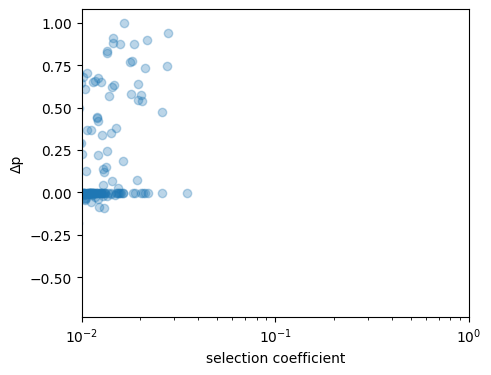

In [13]:
fig, ax1 = plt.subplots(figsize=(5, 4))
scatter = ax1.scatter(s,p[:,0]-p[:,1], alpha=0.3)#, c=old_mut, cmap="PRGn")
ax1.set_ylabel("Δp")
ax1.set_xlabel("selection coefficient")
ax1.set_xscale("log")
ax1.set_xlim(1e-2, 1)
#legend = ax1.legend(*scatter.legend_elements(),loc="lower right", title="msprime\nmutation?")
#ax1.add_artist(legend)
plt.show()

Let's see how mean frequency change (as a proxy for probability of fixation) compares to the classic $p_\text{fix} = 2s$,
in this situation with lots of linkage.

/tmp/ipykernel_274214/2401628094.py:6: RuntimeWarning: invalid value encountered in divide
  mean_dp = sum_dp / denom
/tmp/ipykernel_274214/2401628094.py:7: RuntimeWarning: invalid value encountered in divide
  mean_s = sum_s / denom


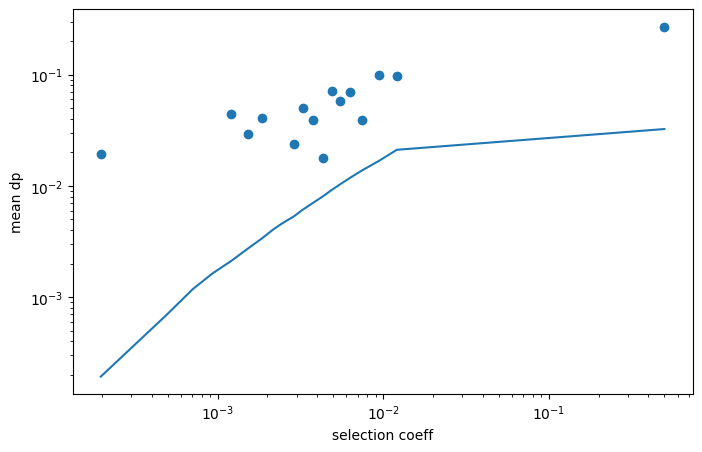

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
sbins = np.concatenate([[0], np.quantile(s, np.linspace(0, 1, 21)[1:-1]), [0.5]])
sum_s = np.bincount(np.searchsorted(sbins, s), weights=s, minlength=len(sbins))
sum_dp = np.bincount(np.searchsorted(sbins, s), weights=p[:,0] - p[:,1], minlength=len(sbins))
denom = np.bincount(np.searchsorted(sbins, s), minlength=len(sbins))
mean_dp = sum_dp / denom
mean_s = sum_s / denom
ax.scatter(sbins, mean_dp)
ax.plot(sbins, 2 * mean_s, label='theory')
ax.set_xscale("log")
ax.set_xlabel("selection coeff"); ax.set_ylabel("mean dp");

## Adding neutral mutations

In [15]:
neutral_mut_map = msprime.RateMap(
           position=breaks,
           rate=[2.97e-8, 2.997e-8, 2.97e-8])
next_id = pyslim.next_slim_mutation_id(ts)
neutral_mut_model = msprime.SLiMMutationModel(
                                type=1,
                                next_id=next_id)
mts = msprime.sim_mutations(
                ts,
                rate=neutral_mut_map,
                model=neutral_mut_model,
                keep=True, 
                random_seed=35)
print(f"The tree sequence now has {mts.num_mutations} mutations,")
print(f"at {mts.num_sites} distinct sites.")

The tree sequence now has 503978 mutations,
at 502549 distinct sites.


In [16]:
num_alleles = np.array([len(s.mutations) for s in mts.sites()])
for k in range(1, max(num_alleles)+1):
  print(f"There are {sum(num_alleles == k)} sites with {k} distinct alleles.")

There are 501122 sites with 1 distinct alleles.
There are 1425 sites with 2 distinct alleles.
There are 2 sites with 3 distinct alleles.


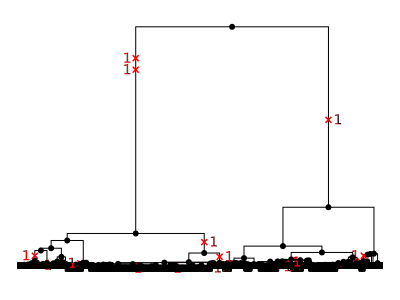

In [17]:
for t in mts.trees():
 mt = [max([u['mutation_type'] for u in m.metadata['mutation_list']]) for m in t.mutations()]
 if t.num_mutations > 12:
   break

ml = {m.id: str(mtype) for mtype, m in zip(mt, t.mutations())}
display(
    t.draw_svg(mutation_labels=ml,
               node_labels={},
               size=(400, 300))
)

In [18]:
for site in mts.sites():
  if len(site.mutations) > 1:
     types = [set([md["mutation_type"] for md in mut.metadata["mutation_list"]])
              for mut in site.mutations]
     if max(map(len, types)) > 1:
        print(site)

Site(id=234725, position=42113907.0, ancestral_state='', mutations=[Mutation(id=235418, site=234725, node=75859, derived_state='587', parent=-1, metadata={'mutation_list': [{'mutation_type': 2, 'selection_coeff': 0.001787469838745892, 'subpopulation': -1, 'slim_time': -15210, 'nucleotide': -1}]}, time=15710.195499152222, edge=563662), Mutation(id=235419, site=234725, node=45084, derived_state='587,238190', parent=235418, metadata={'mutation_list': [{'mutation_type': 2, 'selection_coeff': 0.001787469838745892, 'subpopulation': -1, 'slim_time': -15210, 'nucleotide': -1}, {'mutation_type': 1, 'selection_coeff': 0.0, 'subpopulation': -1, 'slim_time': -1466, 'nucleotide': -1}]}, time=1467.5675972937515, edge=360544)], metadata=b'')


## Diversity along the genome

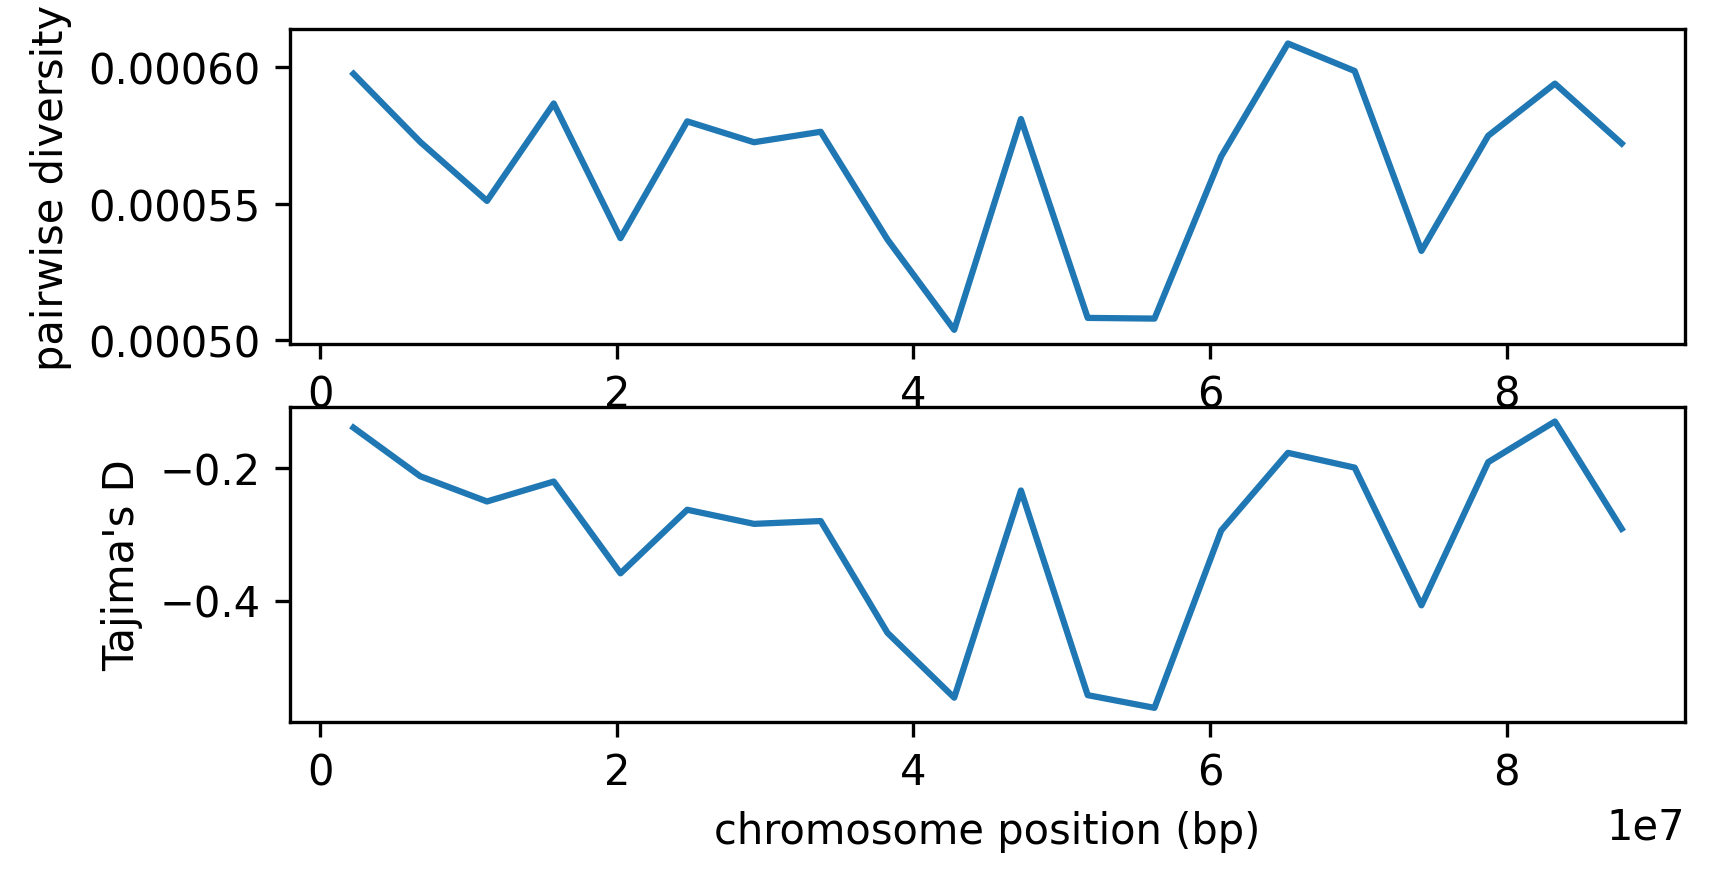

In [19]:
windows = np.linspace(0, mts.sequence_length, 21)
pi = mts.diversity(mts.samples(), windows=windows)
taj_d = mts.Tajimas_D(mts.samples(), windows=windows)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,3), dpi=300)
mids = windows[1:] - np.diff(windows)/2
ax1.set_xlabel("chromosome position (bp)")
ax1.set_ylabel("pairwise diversity")
ax1.plot(mids, pi, label="pairwise diversity")
ax2.set_xlabel("chromosome position (bp)")
ax2.set_ylabel("Tajima's D")
ax2.plot(mids, taj_d, label="Tajima's D");